In [14]:
import os
import pandas as pd
import numpy as np
from glob import glob
import gspread
from haversine import haversine, Unit
import h3

# Goal: 
summarize the classification of each images from the prediction results
## 1. City-level summary
* use the classifier_city_agg.py

In [2]:
label = {0: 'Accra', 1: 'Amsterdam', 2: 'Antwerp', 3: 'Astrakhan', 4: 'Athens', 5: 'Auckland', 6: 'Bacolod', 7: 'Bangalore', 8: 'Bangkok', 9: 'Belgrade', 10: 'Belo Horizonte', 11: 'Berezniki', 12: 'Berlin', 13: 'Bogotá', 14: 'Boston', 15: 'Brussels', 16: 'Budapest', 17: 'Buenos Aires', 18: 'Capetown', 19: 'Cebu City', 20: 'Chicago', 21: 'Cirebon', 22: 'Cleveland', 23: 'Cochabamba', 24: 'Copenhagen', 25: 'Culiacan', 26: 'Curitiba', 27: 'Delhi', 28: 'Denver', 29: 'Detroit', 30: 'Dhaka', 31: 'Dubai', 32: 'Dzerzhinsk', 33: 'Florianopolis', 34: 'Fukuoka', 35: 'Gaborone', 36: 'Gainesville, FL', 37: 'Gombe', 38: 'Guadalajara', 39: 'Guatemala City', 40: 'Hindupur', 41: 'Hong Kong', 42: 'Houston', 43: 'Hyderabad', 44: 'Ilheus', 45: 'Istanbul', 46: 'Jaipur', 47: 'Jakarta', 48: 'Jalna', 49: 'Jequie', 50: 'Jerusalem', 51: 'Johannesburg', 52: 'Kampala', 53: 'Kanpur', 54: 'Kaunas', 55: 'Kigali', 56: 'Killeen', 57: 'Kozhikode', 58: 'Kuala Lumpur', 59: 'Kyiv', 60: 'Lagos', 61: 'Le Mans', 62: 'Lima', 63: 'London', 64: 'Los Angeles', 65: 'Madrid', 66: 'Malegaon', 67: 'Manchester', 68: 'Manila', 69: 'Medan', 70: 'Metro Manila', 71: 'Mexico City', 72: 'Miami', 73: 'Milan', 74: 'Minneapolis', 75: 'Modesto', 76: 'Montreal', 77: 'Moscow', 78: 'Mumbai', 79: 'Munich', 80: 'Nagoya', 81: 'Nairobi', 82: 'New York', 83: 'Okayama', 84: 'Palembang', 85: 'Palermo', 86: 'Palmas', 87: 'Parbhani', 88: 'Parepare', 89: 'Paris', 90: 'Philadelphia', 91: 'Portland, OR', 92: 'Pune', 93: 'Quito', 94: 'Rajshahi', 95: 'Raleigh', 96: 'Reynosa', 97: 'Ribeirao Preto', 98: 'Rio de Janeiro', 99: 'Rome', 100: 'Rovno', 101: 'Saidpur', 102: 'Saint Petersburg', 103: 'San Francisco', 104: 'Santiago', 105: 'Sao Paulo', 106: 'Seoul', 107: 'Sheffield', 108: 'Singapore', 109: 'Sitapur', 110: 'Stockholm', 111: 'Sydney', 112: 'Taipei', 113: 'Tel Aviv', 114: 'Thessaloniki', 115: 'Tokyo', 116: 'Toledo', 117: 'Toronto', 118: 'Tyumen', 119: 'Valledupar', 120: 'Victoria', 121: 'Vienna', 122: 'Vijayawada', 123: 'Warsaw', 124: 'Wellington', 125: 'Yamaguchi', 126: 'Zwolle'}
label_r = {}
for k,v in label.items():
    label_r[v] = k

In [160]:
def load_all():
    serviceaccount = "../../google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)


    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet


    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "select_city_classifier"
    city_meta, other_worksheet = read_url(url, SHEETNAME)
    city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
    return city_meta

city_meta = load_all()

In [163]:
city_meta.to_csv("../city_meta.csv", index = False)

In [3]:
CURATED_FOLDER_TARGET = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg"
CURATED_FOLDER_SOURCE = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_infer"
TRANSFORMED_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_transformed/t_classifier"

# TO_PRED_CITYLS = os.listdir(TRANSFORMED_FOLDER)
CITYLS = os.listdir(CURATED_FOLDER_SOURCE)
# ALLPRED = glob(CURATED_FOLDER_SOURCE+"/*/*.parquet")
# print("Total cities: ", len(CITYLS))
# print("Total files: ", len(ALLPRED))

In [3]:
# TO_PRED_CITYLS = [x[:-4] for x in TO_PRED_CITYLS]
# REMAIN = [x for x in TO_PRED_CITYLS if not x in CITYLS]
# loop through all cities' results and summarize the prediction
from tqdm import tqdm
allresults = []
for city in tqdm(CITYLS):
    city_pred = glob(CURATED_FOLDER_SOURCE +"/"+city+"/*.parquet")
    temp_df = []
    for p in tqdm(city_pred):
        temp = pd.read_parquet(p)
        temp_df.append(temp)
    temp_df = pd.concat(temp_df).reset_index(drop = True)
    temp_sum = temp_df.groupby('top_1').size().reset_index().rename(columns = {0:"count"})
    temp_sum['city'] = city
    allresults.append(temp_sum)
allresults = pd.concat(allresults).reset_index(drop = True)
allresults["top_1_pre"] = allresults["top_1"].apply(lambda x: label[x])
allresults["total_count"] = allresults.groupby("city")["count"].transform("sum")
allresults["pre_pro"] = allresults["count"]/allresults["total_count"]

allresults.to_parquet(os.path.join(CURATED_FOLDER_TARGET, "c_classifier_city_agg.parquet"), index = False)

[]

In [122]:
# testing
allresults = pd.read_parquet(os.path.join(CURATED_FOLDER_TARGET, "c_classifier_city_agg.parquet"))
allresults["img_total"] = allresults.groupby("city")["count"].transform('sum')
allresults["prop"] = allresults["count"]/allresults["img_total"]
allresults["pred_city"] = allresults["top_1"].apply(lambda x: label[x].lower().replace(" ", ""))
allresults[allresults["city"]=="milan"].sort_values("prop", ascending = False).head(20)

,top_1,count,city
0,0,3,stockholm
1,1,741,stockholm
2,2,1133,stockholm
3,3,287,stockholm
4,4,198,stockholm
...,...,...,...
13235,121,727,paris
13236,123,410,paris
13237,124,13,paris
13238,125,8,paris


## 2. Hexagon-level summary
1. What are the second most frequent misclassified city for each city at each hexagon level? Are there any pattern associated with city identity, cultural history, etc?


In [16]:
CURATED_FOLDER_TARGET = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg_hex"
CURATED_FOLDER_SOURCE = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_city_classifier_agg"
city_upper = "London"
city = city_upper.lower().replace(" ", "")
FILE_NAME = f"c_{city}.parquet"
df = pd.read_parquet(os.path.join(CURATED_FOLDER_SOURCE, FILE_NAME))
df.head()

,name,top_1,top_1_prob
0,6aUNfsPyC1iwjzPvXIs2cQ_270.jpg,63,0.611167
1,XnnxJx8vvmhtlVsaeU7z-g_0.jpg,1,0.390610
2,XnnxJx8vvmhtlVsaeU7z-g_90.jpg,107,0.759496
3,XnnxJx8vvmhtlVsaeU7z-g_180.jpg,1,0.370917
4,XnnxJx8vvmhtlVsaeU7z-g_270.jpg,107,0.362673


In [17]:
# RAW_PATH = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{city}/gsvmeta/gsv_pano.csv"
RAW_PATH = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{city}/gsvmeta/{city}_meta.csv"
df_meta = pd.read_csv(RAW_PATH.format(city = city))
df_meta['name'] = df_meta["path"].apply(lambda x: x.split("/")[-1])
df_meta['name'].nunique()

2850718

In [18]:

# get h3
for res in [8,9,12]:
    df_meta[f'h3_{res}'] = df_meta.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)
    
# get distance from city center

In [19]:
df_temp = df.merge(df_meta, on = "name")

In [115]:
# for res in [6,9,12]:
#     df_agg = df_temp.groupby(['top_1',f'h3_{res}']).size().reset_index()

In [20]:
res = 9
df_agg = df_temp.groupby(['top_1',f'h3_{res}']).size().reset_index().rename(columns = {0:"count"})
# df_agg['max_count'] = df_agg.groupby(f"h3_{res}")["count"].transform('max')
df_agg["img_count"] = df_agg.groupby(f"h3_{res}")["count"].transform('sum')

# df_agg['sel_class'] = np.where(df_agg["max_count"]==df_agg["count"], df_agg["top_1"], None)
df_sel = df_agg[df_agg["top_1"]==label_r[city_upper]].reset_index(drop = True)
df_sel["correct_prop"] = df_sel["count"]/df_sel["img_count"]

In [21]:
# give a class to the model selected city
df_agg['max_count'] = df_agg.groupby(f"h3_{res}")["count"].transform('max')
# df_agg['sel_class'] = np.where(df_agg["max_count"]==df_agg["count"], df_agg["top_1"], None)
df_model = df_agg[df_agg["max_count"]==df_agg["count"]].reset_index(drop = True)
df_model["sel_class"] = df_model["top_1"].apply(lambda x: label[x])
df_model

,top_1,h3_9,count,img_count,max_count,sel_class
0,1,89194ac00dbffff,31,116,31,Amsterdam
1,1,89194ac0317ffff,32,120,32,Amsterdam
2,1,89194ad13cfffff,15,100,15,Amsterdam
3,1,89194ad25cbffff,12,63,12,Amsterdam
4,1,89194ad31dbffff,38,105,38,Amsterdam
...,...,...,...,...,...,...
14883,126,89195da688fffff,46,120,46,Zwolle
14884,126,89195dad9a7ffff,47,120,47,Zwolle
14885,126,89195dad9afffff,72,120,72,Zwolle
14886,126,89195dad9bbffff,35,76,35,Zwolle


In [22]:
from shapely.geometry import Polygon
import geopandas as gpd

def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

In [23]:
h3_geoms = df_sel[f'h3_{res}'].apply(lambda x: cell_to_shapely(x))
df_sel_gdf = gpd.GeoDataFrame(df_sel[["top_1", f"h3_{res}","correct_prop"]], geometry = h3_geoms)
df_sel_gdf.crs = "EPSG:4326"

In [24]:
h3_geoms_m = df_model[f'h3_{res}'].apply(lambda x: cell_to_shapely(x))
df_model_gdf = gpd.GeoDataFrame(df_model[["top_1", f"h3_{res}", "sel_class"]], geometry = h3_geoms_m)
df_model_gdf.crs = "EPSG:4326"

<Axes: >

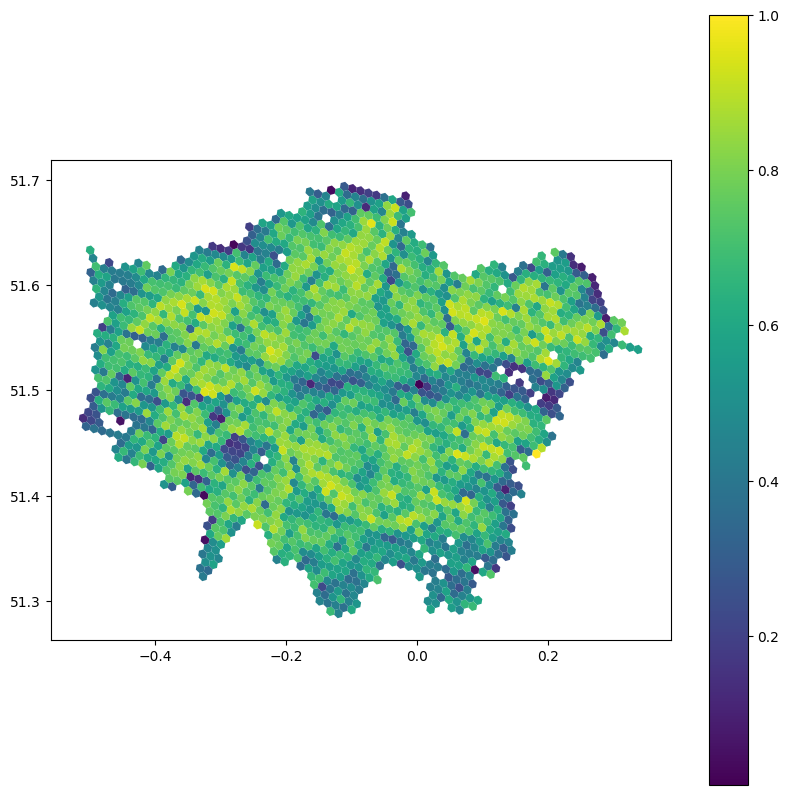

In [157]:
df_sel_gdf.plot(column = "correct_prop", figsize = (10,10), legend = True)

<Axes: >

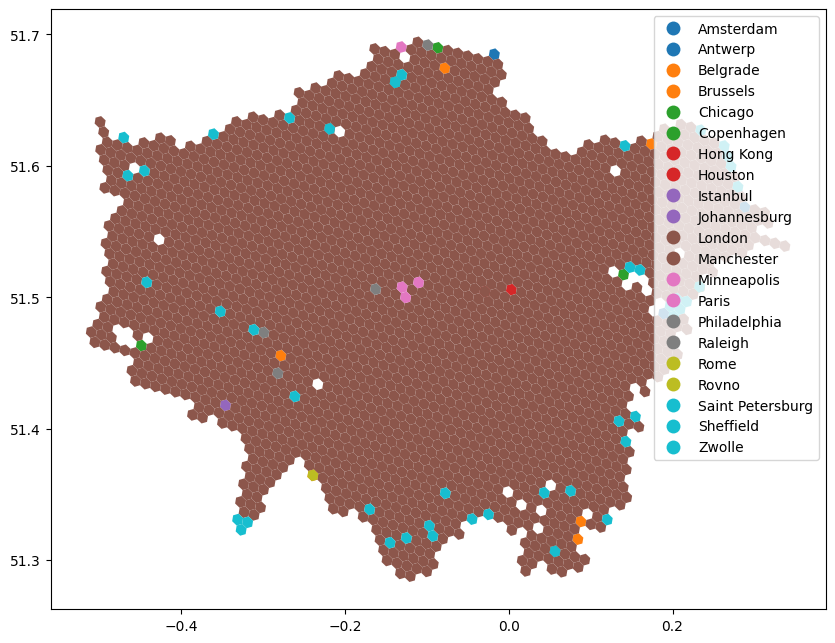

In [158]:
df_model_gdf.plot(column = "sel_class", figsize = (10,10), legend = True)